In [192]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tia-2023/submission.csv
/kaggle/input/tia-2023/train.csv
/kaggle/input/tia-2023/test.csv


In [193]:
# Block for all imports made throught the notebook:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn import svm

In [194]:
# Verify data loading is correct.
train_data = pd.read_csv('/kaggle/input/tia-2023/train.csv')
train_data.head()
test_data = pd.read_csv('/kaggle/input/tia-2023/test.csv')
test_data.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5
0,76.0,88.157573,36.534704,69.591322,51.196027,138.524808,112.732747
1,15.0,44.045246,11.913953,36.958099,30.362537,123.838970,6.458098
2,196.0,63.225218,13.481326,63.388508,50.455107,91.520265,56.674993
3,77.0,59.635309,6.369510,52.696833,50.504349,100.221540,50.597632
4,166.0,56.913632,5.079858,57.683467,49.524329,110.618330,35.270323


In [195]:
# We now are trying to look at the data to understand how the anomalies are spread.
train_data.info()
features_train = train_data.drop(columns=['id', 'is_anomaly'])
anomaly_train = train_data['is_anomaly']

features_test = test_data.drop(columns=['id'])

train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          144 non-null    float64
 1   feature_0   144 non-null    float64
 2   feature_1   144 non-null    float64
 3   feature_2   144 non-null    float64
 4   feature_3   144 non-null    float64
 5   feature_4   144 non-null    float64
 6   feature_5   144 non-null    float64
 7   is_anomaly  144 non-null    float64
dtypes: float64(8)
memory usage: 9.1 KB


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,is_anomaly
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,111.326389,64.226751,19.561420,54.079310,44.703726,117.250586,35.702038,0.097222
std,66.748335,18.145381,10.436813,18.725270,14.851784,13.590508,45.957506,0.297294
min,1.000000,30.577565,-3.653628,18.995085,12.791948,70.660124,-9.957228,0.000000
25%,55.750000,48.680970,12.794194,39.482445,33.876683,110.247439,5.182902,0.000000
50%,106.500000,65.071287,17.890558,51.512030,43.373902,117.117564,27.227696,0.000000
75%,164.750000,76.047032,24.860083,66.524102,55.151957,124.157933,54.205813,0.000000
max,239.000000,128.573395,48.715990,94.829946,122.478511,163.339675,419.262574,1.000000


In [196]:
test_data.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,209.630208,62.250398,17.926074,55.008894,44.286810,114.165483,30.097154
std,95.137452,16.097708,10.451460,19.883281,12.812600,13.572711,28.192111
min,0.000000,26.997378,-7.650561,14.221737,11.204973,82.934180,-12.665816
25%,149.250000,51.828889,11.609624,40.304586,34.351519,105.094410,3.563398
50%,239.000000,61.485335,17.054633,53.299112,45.727571,114.652847,29.109324
75%,287.250000,74.644358,23.415473,64.569508,53.024391,123.144293,46.633370
max,335.000000,95.901798,51.912726,126.299809,70.361605,159.572384,117.367656


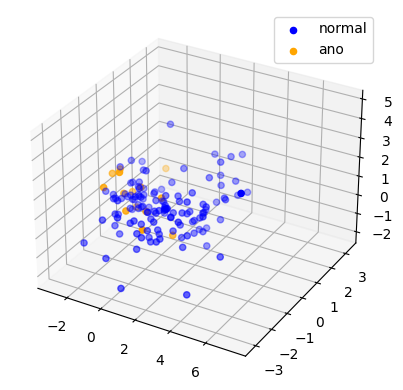

In [197]:
scaler = StandardScaler()
features_train_normalized = scaler.fit_transform(features_train)
Xpca = PCA(n_components=3).fit_transform(features_train_normalized)
idx_normal = anomaly_train==0
idx_ano = anomaly_train==1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(Xpca[idx_normal,0], Xpca[idx_normal,1], Xpca[idx_normal,2], c='blue', label='normal')
ax.scatter(Xpca[idx_ano,0], Xpca[idx_ano,1], Xpca[idx_ano,2], c='orange', label='ano')

ax.legend()
plt.show()
# The data shown seems to suggest that the anomalies have a local type of distribution.

In [198]:
# Applying the IForest algorithm for creating a model.
ForestModel = IsolationForest(max_samples = 144, contamination = float(.17))
ForestModel.fit(features_train_normalized)
anoIF_train_scores = ForestModel.decision_function(features_train_normalized)

features_test_normalized = scaler.fit_transform(features_test)
IF_anomaly = ForestModel.predict(features_test_normalized)
IF_anomaly = np.where(IF_anomaly == -1, 1, np.where(IF_anomaly == 1, 0, IF_anomaly))
print(IF_anomaly, '\n', sum(IF_anomaly))

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1
 0 0 0 1 0 0 0] 
 50


In [199]:
# Applying SVC to create a model.
SVCModel = svm.SVC(C = 25, gamma = 0.4)
SVCModel.fit(features_train_normalized, train_data['is_anomaly'])
SVC_anomaly = SVCModel.predict(features_test_normalized)

print(SVC_anomaly, '\n', sum(SVC_anomaly))

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 
 23.0


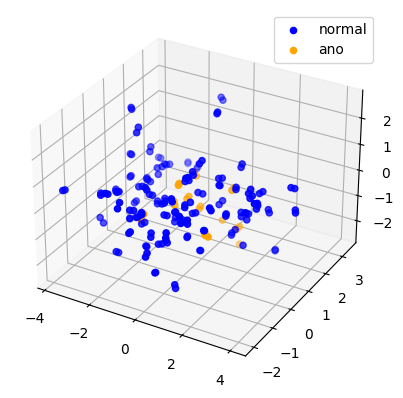

In [201]:
Xpca = PCA(n_components=3).fit_transform(features_test_normalized)
idx_normal = SVC_anomaly==0
idx_ano = SVC_anomaly==1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(Xpca[idx_normal,0], Xpca[idx_normal,1], Xpca[idx_normal,2], c='blue', label='normal')
ax.scatter(Xpca[idx_ano,0], Xpca[idx_ano,1], Xpca[idx_ano,2], c='orange', label='ano')

ax.legend()
plt.show()

In [200]:
# Writing the best result to the "submission.csv".
results = [test_data['id'], SVC_anomaly]
export_res = pd.DataFrame(results)
export_res = export_res.transpose()
export_res.rename(columns={'Unnamed 0': 'is_anomaly'}, inplace=True)
export_res.to_csv('/kaggle/working/predictions.csv', index = False)